In [2]:
#load data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import h5py

data_dir = '/home/abdulla/DATASETS/PENN_UNI_DATASET/indoor_flying/'
event_data = h5py.File(data_dir + 'indoor_flying1_data.hdf5')
gt_data = h5py.File(data_dir + 'indoor_flying1_gt.hdf5')

/home/abdulla/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if __name__ == '__main__':
/home/abdulla/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  # Remove the CWD from sys.path while we load stuff.


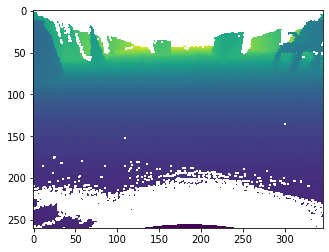

In [3]:
plt.imshow(gt_data['davis']['left']['depth_image_rect'][100])

In [16]:
print(event_data['davis']['left']['events'][1000])

[ 3.35000000e+02  2.34000000e+02  1.50464518e+09 -1.00000000e+00]


In [17]:
def ConcatenateEvent(event_list, time_steps, im_height=260, im_width=346):

    event_images_list = []

    event_iterator = 0
    for ts in time_steps:
        #print(event_iterator)
        event_image = np.zeros((im_height, im_width, 3), dtype=np.float64)
        counter_matrix = np.zeros((im_height, im_width))
        timestamp_matrix = np.zeros((im_height, im_width))
        print("start")
        for i in range(event_iterator, len(event_list)):
            event = np.copy(event_list[i])
            if event[2] > ts:
                event_image[:, :, 2] = np.zeros((im_height, im_width))
                event_image[:, :, 2] = np.divide(timestamp_matrix, counter_matrix, where=counter_matrix!=0)

                event_images_list.append(np.copy(event_image)) 
                event_iterator = i + 1
                break
            else:
                if event[3] > 0:
                    event_image[int(event[1]), int(event[0]), 0] = event_image[int(event[1]), int(event[0]), 0] + 1.0
                else:
                    event_image[int(event[1]), int(event[0]), 1] = event_image[int(event[1]), int(event[0]), 1] + 1.0
                
                counter_matrix[int(event[1]), int(event[0])] = counter_matrix[int(event[1]), int(event[0])] + 1.0                

                timestamp_matrix[int(event[1]), int(event[0])] = (ts - event[2]) + timestamp_matrix[int(event[1]), int(event[0])]


    return event_images_list     

In [33]:
time_steps = np.linspace(gt_data['davis']['left']['depth_image_rect_ts'][0], gt_data['davis']['left']['depth_image_rect_ts'][-1], 100)
event_images = ConcatenateEvent(event_data['davis']['left']['events'], time_steps)

start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start
start


In [7]:
def SelectFrames(images_list, images_ts, desired_timesteps, target_step=0.06):

    desired_frames = []
    images_iterator = 0

    for ts in desired_timesteps:
        for i in range(images_iterator, len(images_list)):
            if np.abs(images_ts[i] - ts) < target_step:
                desired_frames.append(images_list[i])
                images_iterator = i + 1
                break
            elif (images_ts[i] - ts) > 1:
                break

    return(desired_frames)

In [ ]:
frame_images = SelectFrames(event_data['davis']['left']['images_raw'], event_data['davis']['left']['images_raw_ts'], time_steps))
frame_images = SelectFrames(gt_data['davis']['left']['depth_images_rect'], gt_data['davis']['left']['depth_images_rect_ts'], time_steps))

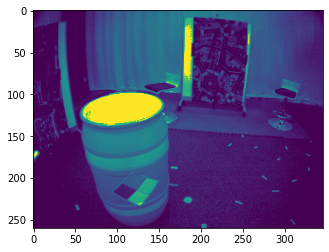

In [84]:
plt.imshow(frame_images[70])

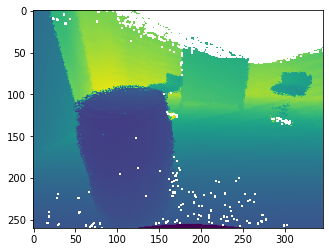

In [85]:
plt.imshow(depth_images[70])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


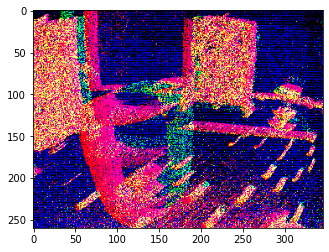

In [133]:
plt.imshow(event_images[70])

In [128]:
#Edge detection of depth image
import cv2


def EdgeDetection(image_list, canny_threshold_1=100, canny_threshold_2=100, convert=False):
    edge_images = []

    for image in image_list:
        temp_image = np.copy(image)
        temp_image[np.isnan(temp_image)] = 0
        if convert:
            temp_image = np.uint8(255 * (temp_image - np.min(temp_image)) / (np.max(temp_image) - np.min(temp_image)))
        edge_images.append(cv2.Canny(temp_image, canny_threshold_1, canny_threshold_2))

    return edge_images
    
def ErodeImages(image_list, kernel_size=5, binary_format=False):
    eroded_images = []
    erosion_kernel = np.ones((kernel_size, kernel_size), np.uint8)
    for image in image_list:
        temp_image = np.copy(image)
        temp_image[np.isnan(temp_image)] = 0.0
        temp_image = 255 * (temp_image - np.min(temp_image)) / (np.max(temp_image) - np.min(temp_image))
        eroded_image = cv2.erode(temp_image, erosion_kernel)
        if binary_format:
            eroded_image[eroded_image>0] = 1
        eroded_images.append(eroded_image)

    return eroded_images

def DiluteImages(image_list, kernel_size=5, binary_format=False):
    diluted_images = []
    dilate_kernel = np.ones((kernel_size, kernel_size), np.uint8)
    for image in image_list:
        temp_image = np.copy(image)
        temp_image[np.isnan(temp_image)] = 0.0
        temp_image = 255 * (temp_image - np.min(temp_image)) / (np.max(temp_image) - np.min(temp_image))
        diluted_image = cv2.dilate(temp_image, dilate_kernel)
        if binary_format:
            diluted_image[diluted_image>0] = 1
        diluted_images.append(diluted_image)

    return diluted_images

def BinaryAddImages(image_list_1, image_list_2):
    summed_images = []
    size = np.min([len(image_list_1), len(image_list_2)])
    for i in range(size):
        summed_images.append(np.logical_or(image_list_1[i], image_list_2[i]))
    
    return summed_images

def MultiplyImages(image_list_1, image_list_2):
    multiplied_images = []
    size = np.min([len(image_list_1), len(image_list_2)])
    for i in range(size):
        multiplied_images.append(np.multiply(image_list_1[i], image_list_2[i]))
    
    return multiplied_images


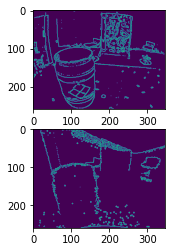

In [96]:
#Edge detection
frame_edges = EdgeDetection(frame_images)
depth_edges = EdgeDetection(depth_images, convert=True)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.imshow(np.array(frame_edges[70]).reshape(260, 346))
ax.autoscale(False)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax, sharey=ax)
ax2.imshow(np.array(depth_edges[70]).reshape(260, 346))
ax2.autoscale(False)
plt.show()

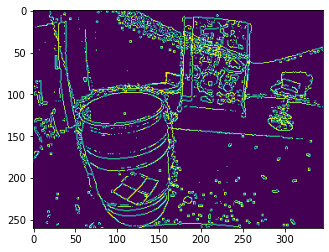

In [109]:
edge_images = BinaryAddImages(frame_edges, depth_edges)

plt.imshow(edge_images[70])

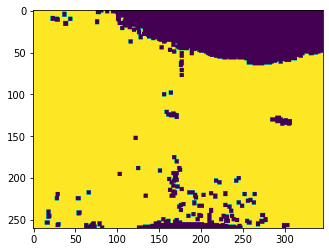

In [83]:
eroded_depth_images = ErodeImages(depth_images, binary_format=True)

plt.imshow(eroded_depth_images[70])

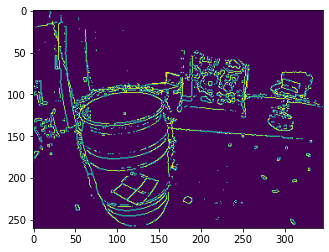

In [124]:
filtered_edge_images = MultiplyImages(edge_images, eroded_depth_images)

plt.imshow(filtered_edge_images[70])

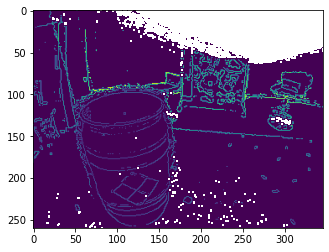

In [123]:
depth_edge_images = MultiplyImages(depth_images, filtered_edge_image)

plt.imshow(depth_edge_images[70])

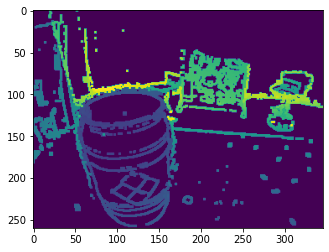

In [130]:
diluted_depth_edge_images = DiluteImages(depth_edge_images,kernel_size=3,  binary_format=False)

plt.imshow(diluted_depth_edge_images[70])

In [134]:
#write data
hf = h5py.File('indoor_flying_preprocessed2.hdf5', 'w')
hf.create_dataset('event_images', data=event_images)
hf.create_dataset('depth_images_timed', data=depth_images)
hf.create_dataset('frame_images_timed', data=frame_images)
hf.create_dataset('edge_images', data=edge_images)
hf.create_dataset('eroded_depth_images', data=eroded_depth_images)
hf.create_dataset('depth_edge_images', data=depth_edge_images)
hf.create_dataset('diluted_depth_edge_images', data=diluted_depth_edge_images)
hf.create_dataset('time_steps', data=time_steps)
hf.close()
